In [2]:
import numpy as np
import h5py as h5
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import re, json
import imageio.v2 as iio
import imageio.v3 as iio3

# Weiss 2a

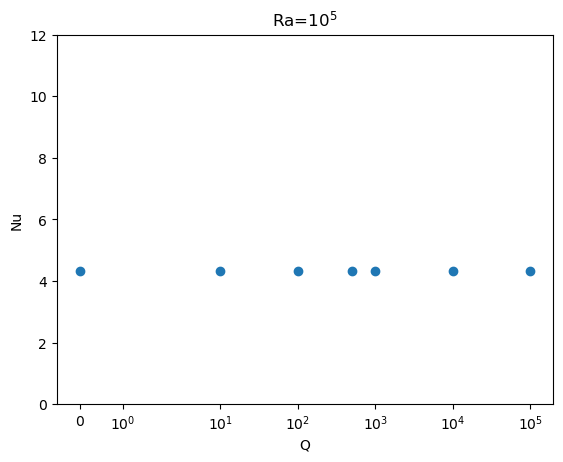

In [3]:
direcs = sorted(list(Path('data/no-slip/Weiss2a/').glob('Q*/outputs.json')),
        key=lambda f: float(re.sub('Q', '', str(f.parent).rsplit('/')[-1])))
Nu = {}
BBNu = {}
WNu = {}
for case in direcs:
    with open(case, 'r') as f:
        info = json.load(f)
    if info['Q'] < 1:
        info['Q'] = 0
    Nu[info['Q']] = info['Nu']
    BBNu[info['Q']] = info['BBNu_bot']
    WNu[info['Q']] = -info['WNu_bot']
plt.scatter(Nu.keys(), Nu.values())
# plt.scatter(WNu.keys(), WNu.values(), marker='+')
# plt.scatter(BBNu.keys(), BBNu.values())
plt.xscale('symlog')
plt.ylim(0, 12)
plt.ylabel("Nu")
plt.xlabel("Q")
plt.title(r"Ra=10$^5$")
plt.savefig('data/no-slip/Weiss2a/Nu_Q.pdf')

# Weiss 3

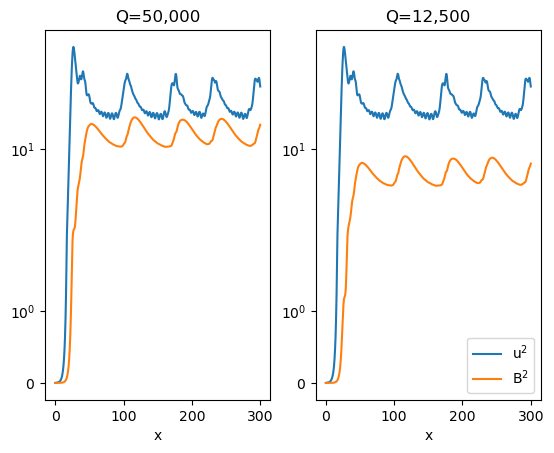

In [32]:
direc = Path('data/Weiss3')
a_dir = direc.joinpath('Q50000')
with h5.File(a_dir.joinpath('analysis/analysis_s1.h5'), 'r') as f:
    time = np.array(f['tasks']['Reavg'].dims[0]['sim_time'])
    u_sq = np.array(f['tasks']['Reavg'])[:, 0, 0]
    B_sq = np.array(f['tasks']['B^2'])[:, 0, 0]
plt.subplot(121)
plt.plot(time, u_sq, label=r'u$^2$')
plt.plot(time, B_sq, label=r'B$^2$')
plt.xlabel('x')
plt.yscale('symlog')
plt.title('Q=50,000')
b_dir = direc.joinpath('Q12500')
with h5.File(b_dir.joinpath('analysis/analysis_s1.h5'), 'r') as f:
    time = np.array(f['tasks']['Reavg'].dims[0]['sim_time'])
    u_sq = np.array(f['tasks']['Reavg'])[:, 0, 0]
    B_sq = np.array(f['tasks']['B^2'])[:, 0, 0]
plt.subplot(122)
plt.plot(time, u_sq, label=r'u$^2$')
plt.plot(time, B_sq, label=r'B$^2$')
plt.xlabel('x')
plt.legend(loc='best')
plt.yscale('symlog')
plt.title('Q=12,500')
plt.savefig(direc.joinpath('u_b_sq.pdf'))

# Weiss 4

Text(0, 0.5, 'Nu')

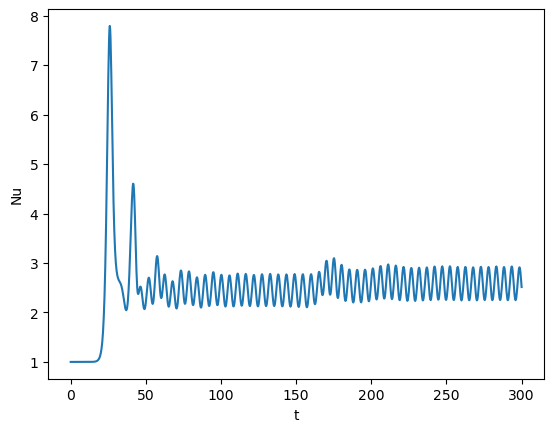

In [35]:
direc = Path('data/no-slip/Weiss4')
with h5.File(direc.joinpath('Q3125/analysis/analysis_s1.h5'), 'r') as f:
    time = np.array(f['tasks']['Nusselt'].dims[0]['sim_time'])
    Nu = np.array(f['tasks']['Nusselt'])[:, 0, 0]

plt.plot(time, Nu)
plt.xlabel('t')
plt.ylabel('Nu')

# Weiss 6

In [3]:
direc = Path('data/Q1e3/1.5e4/')
outpath = direc.joinpath('images/')
outpath.mkdir(exist_ok=True)
snap_files = sorted(list(direc.glob('snapshots/*.h5')), key=lambda f: int(re.sub('\D', '', str(f))))
a_files = sorted(list(direc.glob('analysis/*.h5')), key=lambda f: int(re.sub('\D', '', str(f))))

In [4]:
for i, sfile in enumerate(snap_files):
    if i==0:
        with h5.File(sfile, 'r') as f:
            snap_time = np.array(f['tasks']['buoyancy'].dims[0]['sim_time'])
            x = np.array(f['tasks']['buoyancy'].dims[1]['x'])
            z = np.array(f['tasks']['buoyancy'].dims[2]['z'])
            Temp = np.array(f['tasks']['buoyancy'])
            Bx = np.array(f['tasks']['Bx'])
            Bz = np.array(f['tasks']['Bz'])
            A = np.array(f['tasks']['A'])
    else:
        with h5.File(sfile, 'r') as f:
            snap_time = np.concatenate((snap_time, np.array(f['tasks']['buoyancy'].dims[0]['sim_time'])))
            Temp = np.concatenate((Temp, np.array(f['tasks']['buoyancy'])), axis=0)
            Bx = np.concatenate((Bx, np.array(f['tasks']['Bx'])), axis=0)
            Bz = np.concatenate((Bz, np.array(f['tasks']['Bz'])), axis=0)
            A = np.concatenate((A, np.array(f['tasks']['A'])), axis=0)

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

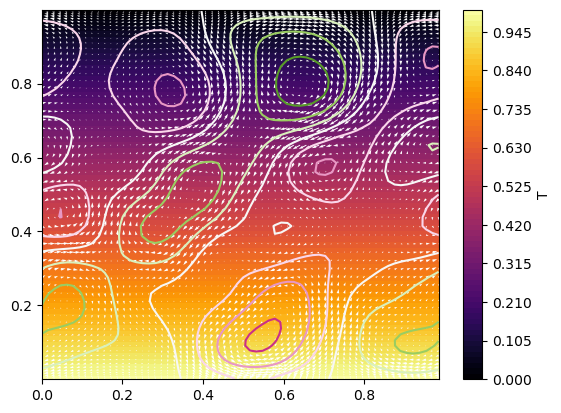

In [ ]:
zz, xx = np.meshgrid(z, x)
fig, ax = plt.subplots()
plt.contourf(xx, zz, Temp[3], 70, cmap='inferno')
# plt.colorbar(label='T')
plt.quiver(xx, zz, Bx[3], Bz[3], color='white')
cs = plt.contour(xx, zz, A[3], cmap='PiYG')
norm = mpl.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cs.cmap)
sm.set_array([])
fig.colorbar(sm, label='B', ticks=cs.levels)

In [ ]:
zz, xx = np.meshgrid(z, x)
cadence = 10
count = 0
fnames = []
direc.joinpath(f"frames").mkdir(exist_ok=True)
for tidx, t in enumerate(snap_time):
    if tidx % cadence != 0:
        continue
    print(f"{t:.1f}/{snap_time[-1]:.1f}", end='\r')
    plt.contourf(xx, zz, Temp[tidx], 75, cmap='inferno')
    plt.colorbar(label='T')
    # if count != 0:
    plt.quiver(xx, zz, Bx[tidx], Bz[tidx], units='xy', color='white', pivot='mid')
    plt.contour(xx, zz, A[tidx])
    plt.colorbar(label='B')
    plt.title(fr"{t:.2f} $\tau_{{ff}}$")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('z')
    fnames.append(direc.joinpath(f'frames/{count:0>3d}.jpg'))
    plt.savefig(fnames[-1], dpi=500)
    plt.clf()
    count += 1

<Figure size 640x480 with 0 Axes>

In [177]:
with iio.get_writer(outpath.joinpath('heatmap.gif'), mode="I") as writer:
    for i, filename in enumerate(fnames):
        print(f"\t frame {i+1}/{len(fnames)}", end="\r")
        image = iio.imread(filename)
        writer.append_data(image)

In [ ]:
for i, afile in enumerate(a_files):
    if i==0:
        with h5.File(afile, 'r') as f:
            atime = np.array(f['tasks']['Reavg'].dims[0]['sim_time'])
            T_prof = np.array(f['tasks']['<T>_x'])[:, 0, :]
            F_conv  = np.array(f['tasks']['L_conv'])[:, 0, :]
            F_cond = np.array(f['tasks']['L_cond_tot'])[:, 0, :]
            ME = np.array(f['tasks']['ME'])[:, 0, :]
            Re_inst = np.array(f['tasks']['Reavg'])[:, 0, 0]
            Nu_inst = np.array(f['tasks']['Nusselt'])[:, 0, 0]
    else:
        with h5.File(afile, 'r') as f:
            atime = np.concatenate((atime, np.array(f['tasks']['Reavg'].dims[0]['sim_time'])), axis=0)
            T_prof = np.concatenate((T_prof, np.array(f['tasks']['<T>_x'])[:, 0. :]), axis=0)
            F_conv = np.concatenate((F_conv, np.array(f['tasks']['L_conv'])[:, 0, :]), axis=0)
            F_cond = np.concatenate((F_cond, np.array(f['tasks']['L_cond_tot'])[:, 0, :]), axis=0)
            ME = np.concatenate((ME, np.array(f['tasks']['ME'])[:,0,:]), axis=0)
            Re_inst = np.concatenate((Re_inst, np.array(f['tasks']['Reavg'])[:, 0, 0]), axis=0)
            Nu_inst = np.concatenate((Nu_inst, np.array(f['tasks']['Nusselt'])[:, 0, 0]), axis=0)

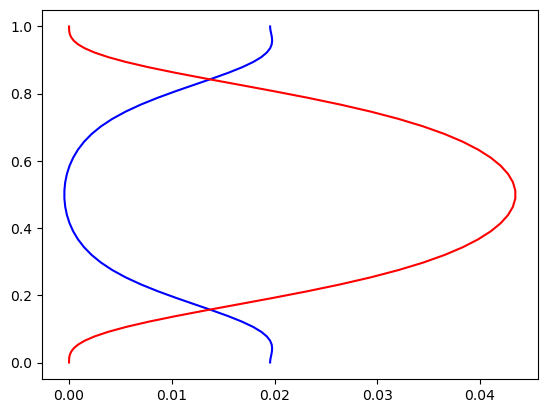

In [ ]:
# plt.plot(T_prof[100], z, c='k')
plt.plot(F_cond[100], z, c='blue')
plt.plot(F_conv[100], z, c='red')
# plt.plot(ME[100], z, c='green')
# plt.plot(F_cond[100]+F_conv[100], z, c='k')


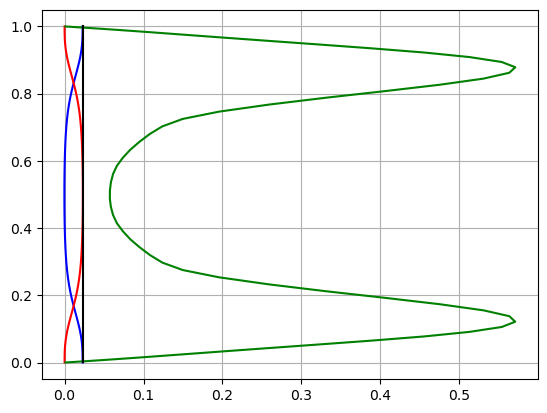

In [160]:
ASI = np.abs(atime-100).argmin()
AEI = -1
F_cond_bar = np.nanmean(F_cond[ASI:AEI, :], axis=0)
F_conv_bar = np.nanmean(F_conv[ASI:AEI, :], axis=0)
ME_bar = np.nanmean(ME[ASI:AEI, :], axis=0)
plt.plot(F_cond_bar, z, c='blue')
plt.plot(F_conv_bar, z, c='red')
plt.plot(ME_bar, z, c='green')
plt.plot(F_cond_bar + F_conv_bar, z, c='k')
plt.grid()

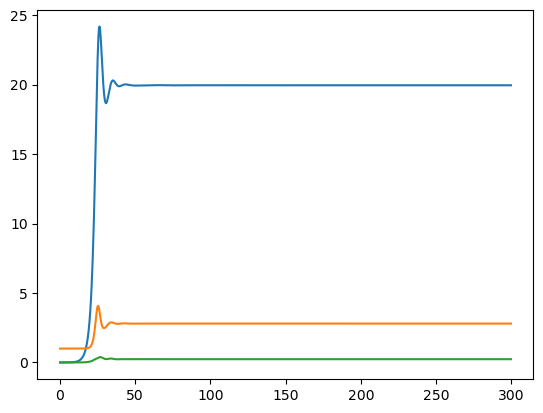

In [145]:
plt.plot(atime, Re_inst)
plt.plot(atime, Nu_inst)
ME_avg = np.trapz(ME, x=z, axis=1)
plt.plot(atime, ME_avg)